In [2]:
from tsai.all import *
computer_setup()

os             : Linux-5.4.0-122-generic-x86_64-with-glibc2.27
python         : 3.8.13
tsai           : 0.3.1
fastai         : 2.7.9
fastcore       : 1.5.27
torch          : 1.11.0+cu102
device         : 1 gpu (['NVIDIA GeForce RTX 3090'])
cpu cores      : 64
RAM            : 503.78 GB
GPU memory     : [24.0] GB


In [2]:
import numpy as np
from glob import glob
import pickle
import pandas as pd
import random
import torch
from tqdm import tqdm

data_path='./data/Train'#存放数据的路径
pkl_files = glob(data_path+'/*.pkl')
ind_pkl_files = []#存放标签为0的文件
ood_pkl_files = []#存放标签为1的文件
for each_path in tqdm(pkl_files):
    pic = open(each_path,'rb')
    this_pkl_file= pickle.load(pic)#下载pkl文件
    if this_pkl_file[1]['label'] == '00':
        ind_pkl_files.append(each_path)
    else:
        ood_pkl_files.append(each_path)

all_pkl_files=ind_pkl_files+ood_pkl_files

random.seed(0)
#排序并打乱存放车辆序号的集合
random.shuffle(ind_pkl_files)
random.shuffle(ood_pkl_files)
random.shuffle(all_pkl_files)

100%|██████████| 28389/28389 [00:01<00:00, 18824.68it/s]


In [3]:
def  load_data(pkl_list,label=True):
    '''
    输入pkl的列表，进行文件加载
    label=True用来加载训练集
    label=False用来加载真正的测试集，真正的测试集无标签
    '''
    X = []
    y = []
    

    for  each_pkl in pkl_list:
        pic = open(each_pkl,'rb')
        item= pickle.load(pic)
        X.append(item[0][:,0:7])
        if label:
            y.append(int(item[1]['label'][0]))
    X = np.dstack(X)
    if label:
        y = np.vstack(y)
    return X, y

In [4]:
train_pkl_files=[]

for i in range(int(len(all_pkl_files)*0.9)):
    train_pkl_files.append(all_pkl_files[i])
test_pkl_files=[]
for j in range(int(len(all_pkl_files)*0.9),len(all_pkl_files)):
    test_pkl_files.append(all_pkl_files[j])

X_train,y_train=load_data(train_pkl_files)
X_test,y_test=load_data(test_pkl_files)

In [5]:
X_train.shape

(256, 7, 25550)

In [6]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [7]:
import torch

In [8]:
X_train = torch.from_numpy(X_train)
X_train=X_train.float()

In [12]:
X_train=X_train.transpose_(0,2)
X_train.shape

torch.Size([25550, 7, 256])

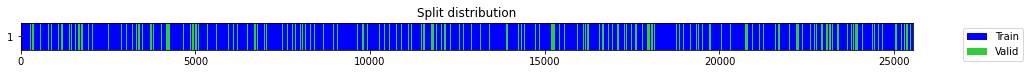

In [13]:
splits = get_splits(y_train, valid_size=.2, stratify=True, random_state=4869, shuffle=True)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_train, y_train, splits= splits ,tfms=tfms, inplace=True)

In [14]:
bs=64
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [15]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(100, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, total_params(model)[0], vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

FCN


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [23]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89


In [6]:
import torch
torch.Tensor([1.,0.]).cuda()

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.